In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer

from sklearn.impute import SimpleImputer


In [2]:
train_X = pd.read_csv("train_X.csv")
train_y = pd.read_csv("train_y.csv")
public_private = pd.read_csv("public_private_X.csv")

In [3]:
all_data = pd.merge(train_X, train_y)

In [4]:
all_data.select_dtypes(include = 'number').corrwith(all_data['ON_TIME_AND_COMPLETE'])

/Users/bellaseo/Desktop/stat 303-2/classification problem/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/bellaseo/Desktop/stat 303-2/classification problem/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ID                                      -0.009594
DIVISION_NUMBER                         -0.025631
PRODUCT_NUMBER                           0.011300
COMPANY_VENDOR_NUMBER                    0.238684
SHIP_FROM_VENDOR                         0.068787
ORDER_DAY_OF_WEEK                       -0.028731
PRODUCT_CLASSIFICATION                   0.266281
PURCHASE_ORDER_TYPE                     -0.010708
DISTANCE_IN_MILES                       -0.118058
PURCHASE_FROM_VENDOR                     0.199145
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET   -0.095015
ORDER_QUANTITY_DEVIATION                 0.006848
TRANSIT_LEAD_TIME                       -0.128883
PURCHASING_LEAD_TIME                    -0.164594
DAYS_BETWEEN_ORDER_AND_DUE_DATE         -0.141651
GIVEN_TIME_TO_LEAD_TIME_RATIO            0.101843
DUE_DATE_WEEKDAY                         0.015874
PRODUCT_MARKET                          -0.018960
PRODUCT_STATUS                                NaN
AVERAGE_DAILY_DEMAND_CASES               0.091601


In [5]:
all_data.dtypes

ID                                         int64
DIVISION_NUMBER                            int64
PRODUCT_NUMBER                             int64
PURCHASE_ORDER_DUE_DATE                   object
COMPANY_VENDOR_NUMBER                      int64
SHIP_FROM_VENDOR                           int64
ORDER_DATE                                object
ORDER_DAY_OF_WEEK                          int64
PRODUCT_CLASSIFICATION                     int64
PURCHASE_ORDER_TYPE                        int64
DISTANCE_IN_MILES                        float64
DIVISION_CODE                             object
PURCHASE_FROM_VENDOR                       int64
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET    float64
ORDER_QUANTITY_DEVIATION                 float64
TRANSIT_LEAD_TIME                        float64
PURCHASING_LEAD_TIME                     float64
DAYS_BETWEEN_ORDER_AND_DUE_DATE            int64
GIVEN_TIME_TO_LEAD_TIME_RATIO            float64
DUE_DATE_WEEKDAY                           int64
PRODUCT_MARKET      

<Axes: >

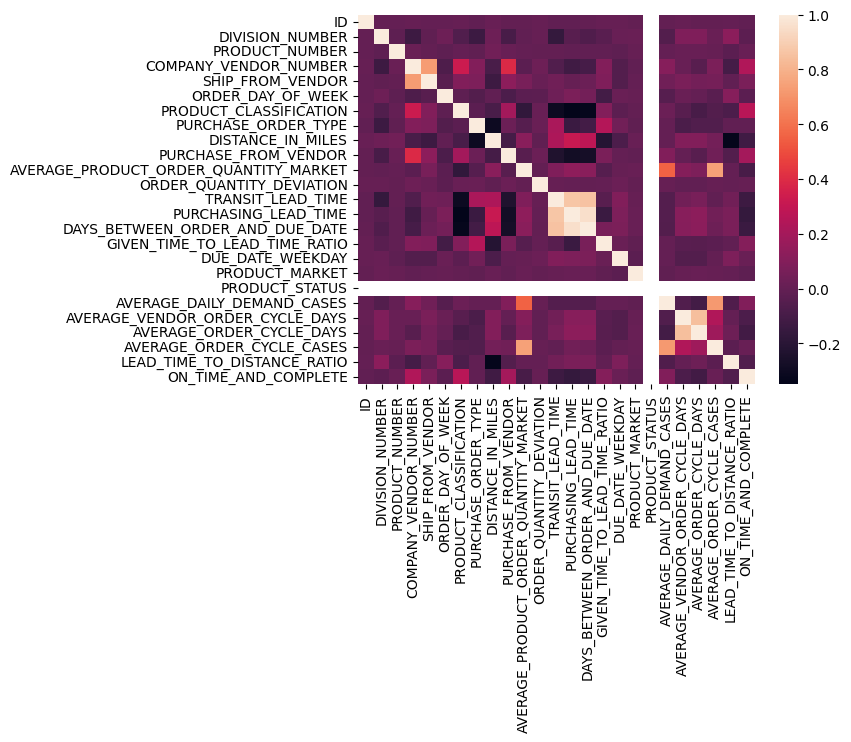

In [6]:
# correlation matrix
sns.heatmap(all_data.select_dtypes(include = 'number').corr())

<Axes: xlabel='LEAD_TIME_TO_DISTANCE_RATIO', ylabel='ON_TIME_AND_COMPLETE'>

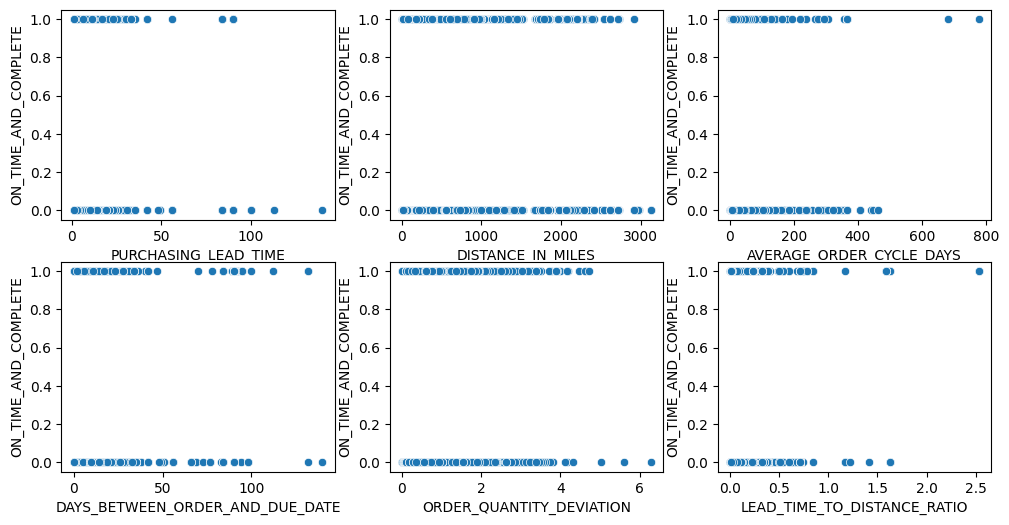

In [7]:
# plots
fig, axes = plt.subplots(2, 3, figsize=(12,6))
sns.scatterplot(x = 'PURCHASING_LEAD_TIME', y = 'ON_TIME_AND_COMPLETE', data = all_data, ax = axes[0,0])
sns.scatterplot(x = 'DISTANCE_IN_MILES', y = 'ON_TIME_AND_COMPLETE', data = all_data, ax = axes[0,1])
sns.scatterplot(x = 'AVERAGE_ORDER_CYCLE_DAYS', y = 'ON_TIME_AND_COMPLETE', data = all_data, ax = axes[0,2])
sns.scatterplot(x = 'DAYS_BETWEEN_ORDER_AND_DUE_DATE', y = 'ON_TIME_AND_COMPLETE', data = all_data, ax = axes[1,0])
sns.scatterplot(x = 'ORDER_QUANTITY_DEVIATION', y = 'ON_TIME_AND_COMPLETE', data = all_data, ax = axes[1,1])
sns.scatterplot(x = 'LEAD_TIME_TO_DISTANCE_RATIO', y = 'ON_TIME_AND_COMPLETE', data = all_data, ax = axes[1,2])

<Axes: xlabel='ON_TIME_AND_COMPLETE', ylabel='count'>

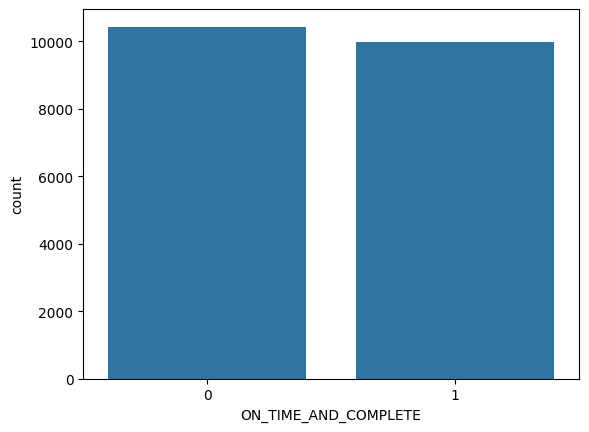

In [8]:
sns.countplot(x = 'ON_TIME_AND_COMPLETE', data = all_data)

In [9]:
train = all_data.drop(columns = ['ID', 'AVERAGE_DAILY_DEMAND_CASES', 'AVERAGE_VENDOR_ORDER_CYCLE_DAYS', 'AVERAGE_ORDER_CYCLE_CASES', 'PURCHASE_ORDER_DUE_DATE', 'ORDER_DATE', 'RESERVABLE_INDICATOR', 'TRANSIT_LEAD_TIME', 'DAYS_BETWEEN_ORDER_AND_DUE_DATE'])

In [10]:
train.columns

Index(['DIVISION_NUMBER', 'PRODUCT_NUMBER', 'COMPANY_VENDOR_NUMBER',
       'SHIP_FROM_VENDOR', 'ORDER_DAY_OF_WEEK', 'PRODUCT_CLASSIFICATION',
       'PURCHASE_ORDER_TYPE', 'DISTANCE_IN_MILES', 'DIVISION_CODE',
       'PURCHASE_FROM_VENDOR', 'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET',
       'ORDER_QUANTITY_DEVIATION', 'PURCHASING_LEAD_TIME',
       'GIVEN_TIME_TO_LEAD_TIME_RATIO', 'DUE_DATE_WEEKDAY', 'PRODUCT_MARKET',
       'PRODUCT_STATUS', 'AVERAGE_ORDER_CYCLE_DAYS',
       'LEAD_TIME_TO_DISTANCE_RATIO', 'ON_TIME_AND_COMPLETE'],
      dtype='object')

In [11]:
X_train = train.drop(columns = 'ON_TIME_AND_COMPLETE')
y_train = train['ON_TIME_AND_COMPLETE']

In [12]:
preprocessor = ColumnTransformer(
    transformers=[('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler())]), ['PURCHASING_LEAD_TIME', 'DISTANCE_IN_MILES', 'AVERAGE_ORDER_CYCLE_DAYS', 'LEAD_TIME_TO_DISTANCE_RATIO', 'ORDER_QUANTITY_DEVIATION']),
        
        ('scale', StandardScaler(), ['AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET']),
        
        ('cat', Pipeline([
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), ['PRODUCT_CLASSIFICATION', 'DIVISION_CODE', 'DIVISION_NUMBER', 'DUE_DATE_WEEKDAY', 'ORDER_DAY_OF_WEEK', 'COMPANY_VENDOR_NUMBER'])
    ])


pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', LogisticRegression(penalty = None, max_iter = 700)) 
])

In [13]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PURCHASING_LEAD_TIME',
                                                   'DISTANCE_IN_MILES',
                                                   'AVERAGE_ORDER_CYCLE_DAYS',
                                                   'LEAD_TIME_TO_DISTANCE_RATIO',
                                                   'ORDER_QUANTITY_DEVIATION']),
                                                 ('scale', StandardScaler(),
                                                  ['AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['PRODUCT_CLASSIFICATION',
                                                   'DIVISION_CODE',
                                                   'DIVISION_NUMBER',
                                                   'DUE_DATE_WEEKDAY',
                                                   'ORDER_DAY_OF_WEEK',
                                                   'COMPANY_VENDOR_NUMBER'])])),
                ('classifier', LogisticRegression(max_iter=700, penalty=None))])

In [14]:
y_pred = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred)
print(train_accuracy)

0.7906236222015383


In [15]:
# export to csv for kaggle submissions
import csv 

public_private['ON_TIME_AND_COMPLETE'] = pipeline.predict(public_private)

sk_submission1 = public_private[['ID', 'ON_TIME_AND_COMPLETE']]

sk_submission1.to_csv('sk_submission1.csv', index=False)

In [16]:
public_private['ON_TIME_AND_COMPLETE']

0        1
1        1
2        1
3        1
4        1
        ..
10242    1
10243    0
10244    1
10245    0
10246    1
Name: ON_TIME_AND_COMPLETE, Length: 10247, dtype: int64